# Data Preprocessing
While from imagenet might need little processing. To retrain Resnet-50 with adversarial inputs, they need to be generated. Training dataset has about 1M images, preprocessing, generates adversarial input for both training and testing datasets.
Corresponding adversarial tensorflow records are created for both datasets.

In [3]:
%pip install tensorflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 126.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 140.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 160.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.4 MB/s eta 0:00:00


In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

# Constants
IMG_SIZE = 224
# BATCH_SIZE = 5000
BATCH_SIZE = 200
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 5
tf.random.set_seed(5)

physical_gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_gpus)

try:
    tf.keras.mixed_precision.set_global_policy('float32')
    # tf.config.experimental.set_virtual_device_configuration(
    #     physical_gpus[0],
    #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=56320)]  # Limit RAM to 55GB to avoid starving PC
    # )
    print("Using GPU with 55GB of memory")
except Exception as e:
    print(e)


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Available GPUs: []
Using GPU with 55GB of memory


Mounted at /content/drive


In [7]:
# Load ImageNet data

def prepare_input_data(input):
    image = tf.cast(input['image'], tf.float32) # ResNet-50 used this
    image = tf.image.resize(input['image'], (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)
    label = input['label']
    return image, label

# Big dataset for real work
# dataset, info = tfds.load(
#     'imagenet2012',
#     shuffle_files=False,
#     with_info=True,
#     data_dir='../datasets'
# )

# Smaller dataset for testing
dataset, info = tfds.load(
    'imagenette',
    shuffle_files=False,
    with_info=True,
    data_dir=dataset_dir
)

# Dataset stats
print(f"Train image count: {info.splits['train'].num_examples}")
print(f"Test image count: {info.splits['validation'].num_examples}")

# Preprocess data
train_dataset = dataset['train'].map(prepare_input_data, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = dataset['validation'].map(prepare_input_data, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

Train image count: 9469
Test image count: 3925


In [8]:
# Load ResNet50 model
from tensorflow.keras.applications import ResNet50

# base_model = ResNet50(
#     include_top=True,
#     weights='imagenet',
#     input_shape=(IMG_SIZE, IMG_SIZE, 3),
#     pooling=None,
#     classes=1000,
#     classifier_activation='softmax'
# )
base_model = ResNet50(
    include_top=True,
    weights=None,  # Don't load pretrained weights since we're changing the output
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling=None,
    classes=10,  # Imagenette has 10 classes
    classifier_activation='softmax'
)

In [9]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # get value from EagerTensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _create_adversary_with_pgd(model, images, labels, eps, eps_iter, nb_iter):
    """
    This generates adversarial images by iteratively applying a small
    perturbation in the direction of the gradient of the loss, and then
    projecting the result back into the epsilon-ball of the original image.

    Args:
        model (tf.keras.Model): The model to attack.
        images (tf.Tensor): The original, clean input images.
        labels (tf.Tensor): The true labels for the images.
        eps (float): The maximum perturbation (L-infinity norm).
        eps_iter (float): The step size for each attack iteration.
        nb_iter (int): The number of PGD iterations to perform.

    Returns:
        tf.Tensor: The generated adversarial images.
    """
    x_adv = tf.identity(images)
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

    for _ in range(nb_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            prediction = model(x_adv, training=False)
            loss = loss_object(labels, prediction)

        gradients = tape.gradient(loss, x_adv)
        signed_grad = tf.sign(gradients)
        x_adv = x_adv + eps_iter * signed_grad
        perturbation = tf.clip_by_value(x_adv - images, -eps, eps)
        x_adv = images + perturbation

    return x_adv

def generate_adversarial_dataset(filename,dataset, model, eps, pgd_steps, pgd_step_size):
    """
    Generates adversarial examples and saves them to a TFRecord file
    by serializing the raw float32 tensors.
    """
    options = tf.io.TFRecordOptions(compression_type="GZIP")
    num = 0
    with tf.io.TFRecordWriter(filename, options=options) as writer:
        for i, (images, labels) in enumerate(dataset):
            print(f"Batch {i+1}")
            # Generate the adversarial images (these are already preprocessed)
            adv_images = _create_adversary_with_pgd(
                model=model,
                images=images,
                labels=labels,
                eps=eps,
                eps_iter=pgd_step_size,
                nb_iter=pgd_steps
            )

            # Iterate through the batch to save each image/label pair
            for i in range(len(adv_images)):
                image_tensor = adv_images[i]
                label = labels[i]

                # 1. Cast the tensor to float16 to halve its size
                image_tensor_f16 = tf.cast(image_tensor, tf.float16)

                # 2. Serialize the smaller tensor
                image_bytes = tf.io.serialize_tensor(image_tensor_f16)
                # 2. Create the feature and write to the TFRecord file
                feature = {
                    'image': _bytes_feature(image_bytes), # Save the raw serialized tensor
                    'label': _int64_feature(label.numpy())
                }
                num += 1
                serialized_example = tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()
                writer.write(serialized_example)

    print(f"Processed and saved: {num} images")


In [11]:
## Adversarial dataset
adversarial_test_file = f"{dataset_dir}/adversaries/small_test_dataset.tfrec"
adversarial_train_file = f"{dataset_dir}/adversaries/small_train_dataset.tfrec"

In [12]:
## Load data from file
def _parse_function(proto):
    """
    Parses a single example proto by deserializing the float16 tensor
    and casting it back to float32.
    """
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(proto, feature_description)

    # 1. Deserialize the byte string back into a float16 tensor
    image_f16 = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float16)
    label = parsed_features['label']

    # 2. Cast the image back to float32 for the model
    image_f32 = tf.cast(image_f16, tf.float32)

    # 3. Set the shape on the final float32 tensor
    image_f32.set_shape([IMG_SIZE, IMG_SIZE, 3])

    return image_f32, label

# Load the TFRecord file back into a dataset
loaded_test_dataset = tf.data.TFRecordDataset(adversarial_test_file, compression_type='GZIP')

# Map the parsing function across the dataset
parsed_test_dataset = loaded_test_dataset.map(_parse_function).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
# Compile model
# First, update the model compilation to include more metrics
base_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        # tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
        tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        # tf.keras.metrics.Precision(average='macro', name='precision'),
        # tf.keras.metrics.Recall(average='macro', name='recall')
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


print("Training the model on clean data...\n")
history = base_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Training the model on clean data...

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd_2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-3671154102.py", line 21, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 85, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/trainer.py", line 490, in compute_metrics

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/compile_utils.py", line 334, in update_state

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/compile_utils.py", line 21, in update_state

  File "/usr/local/lib/python3.12/dist-packages/keras/src/metrics/confusion_metrics.py", line 378, in update_state

  File "/usr/local/lib/python3.12/dist-packages/keras/src/metrics/metrics_utils.py", line 592, in update_confusion_matrix_variables

  File "/usr/local/lib/python3.12/dist-packages/keras/src/metrics/metrics_utils.py", line 565, in weighted_assign_add

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/numpy.py", line 3823, in logical_and

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1673, in logical_and

Incompatible shapes: [1,5000] vs. [1,500]
	 [[{{node LogicalAnd_2}}]] [Op:__inference_multi_step_on_iterator_45581]

In [ ]:
# Evaluate model on all datasets
print("Computing baseline metrics...\n")

train_metrics = base_model.evaluate(train_dataset, verbose=1)
test_metrics = base_model.evaluate(test_dataset, verbose=1)
noisy_metrics = base_model.evaluate(parsed_test_dataset, verbose=1)

# Extract metrics
# train_loss, train_acc, train_top5, train_auc, train_prec, train_rec = train_metrics
# test_loss, test_acc, test_top5, test_auc, test_prec, test_rec = test_metrics
# noisy_loss, noisy_acc, noisy_top5, noisy_auc, noisy_prec, noisy_rec = noisy_metrics

try:
    # Extract metrics with error handling
    metric_names = ['loss', 'accuracy', 'top_5_accuracy', 'sparse_categorical_accuracy', 'auc', 'precision', 'recall']
    metrics_dict = {
        'train': dict(zip(metric_names, train_metrics)),
        'test': dict(zip(metric_names, test_metrics)),
        'noisy': dict(zip(metric_names, noisy_metrics))
    }

    # Unpack metrics safely
    train_loss, train_acc = metrics_dict['train']['loss'], metrics_dict['train']['accuracy']
    train_top5, train_auc = metrics_dict['train']['top_5_accuracy'], metrics_dict['train']['auc']
    train_prec, train_rec = metrics_dict['train']['precision'], metrics_dict['train']['recall']

    test_loss, test_acc = metrics_dict['test']['loss'], metrics_dict['test']['accuracy']
    test_top5, test_auc = metrics_dict['test']['top_5_accuracy'], metrics_dict['test']['auc']
    test_prec, test_rec = metrics_dict['test']['precision'], metrics_dict['test']['recall']

    noisy_loss, noisy_acc = metrics_dict['noisy']['loss'], metrics_dict['noisy']['accuracy']
    noisy_top5, noisy_auc = metrics_dict['noisy']['top_5_accuracy'], metrics_dict['noisy']['auc']
    noisy_prec, noisy_rec = metrics_dict['noisy']['precision'], metrics_dict['noisy']['recall']

except Exception as e:
    print(f"Error extracting metrics: {e}")
    print("Available metrics:", base_model.metrics_names)
    raise

print("\n" + "="*50)
print("       Model Performance Analysis")
print("="*50 + "\n")

print("## Base Performance Metrics 📊")
print("**Evaluated on clean test dataset**\n")
print(f"* **Top-1 Accuracy**: `{test_acc*100:.2f}%`")
print(f"* **Top-5 Accuracy**: `{test_top5*100:.2f}%`")
print(f"* **AUC Score**: `{test_auc:.3f}`")
print(f"* **Precision**: `{test_prec:.3f}`")
print(f"* **Recall**: `{test_rec:.3f}`")
print(f"* **Loss**: `{test_loss:.3f}`")
print("\n" + "---")

print("\n## Generalization Analysis 🧠")
print("**Comparing training vs test performance**\n")
print(f"* **Training Accuracy**: `{train_acc*100:.2f}%`")
print(f"* **Test Accuracy**: `{test_acc*100:.2f}%`")
print(f"* **Generalization Gap**: `{(train_acc-test_acc)*100:.2f}%`")
print(f"* **Training Loss**: `{train_loss:.3f}`")
print(f"* **Test Loss**: `{test_loss:.3f}`")
print("> *A smaller gap indicates better generalization*")
print("\n" + "---")

print("\n## Adversarial Robustness 🛡️")
print("**Evaluating model stability against adversarial inputs**\n")
print(f"* **Clean Data Accuracy**: `{test_acc*100:.2f}%`")
print(f"* **Adversarial Data Accuracy**: `{noisy_acc*100:.2f}%`")
print(f"* **Robustness Gap**: `{(test_acc-noisy_acc)*100:.2f}%`")
print(f"* **Clean AUC**: `{test_auc:.3f}`")
print(f"* **Adversarial AUC**: `{noisy_auc:.3f}`")
print("> *Smaller gaps between clean and adversarial metrics indicate better robustness*")

In [ ]:
# save_processed_dataset('../datasets/adversaries/train_dataset.tfrecord', adversarial_train_dataset)
# %reset_selective -f adversarial_train_dataset train_dataset
# import gc;gc.collect()

In [ ]:
## Adversarial training
# Load the TFRecord file back into a dataset
loaded_train_dataset = tf.data.TFRecordDataset(adversarial_train_file, compression_type='GZIP')

# Map the parsing function across the dataset
parsed_train_dataset = loaded_train_dataset.map(_parse_function).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

history = base_model.fit(
    parsed_train_dataset,
    epochs=5, # Use a suitable number of epochs for your task
    validation_data=parsed_test_dataset,
    verbose=0
)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# First compile model with comprehensive metrics
base_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Evaluate model on all datasets
print("Computing comprehensive metrics...\n")

train_metrics = base_model.evaluate(train_dataset, verbose=0)
test_metrics = base_model.evaluate(test_dataset, verbose=0)
noisy_metrics = base_model.evaluate(parsed_test_dataset, verbose=0)

# Extract all metrics
train_loss, train_acc, train_top5, train_auc, train_prec, train_rec = train_metrics
test_loss, test_acc, test_top5, test_auc, test_prec, test_rec = test_metrics
noisy_loss, noisy_acc, noisy_top5, noisy_auc, noisy_prec, noisy_rec = noisy_metrics

# Create figure for multiple plots
plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 10))

# 1. Accuracy Comparison
plt.subplot(2, 2, 1)
metrics = ['Top-1 Acc', 'Top-5 Acc', 'AUC']
clean_scores = [test_acc*100, test_top5*100, test_auc*100]
noisy_scores = [noisy_acc*100, noisy_top5*100, noisy_auc*100]

x = range(len(metrics))
width = 0.35

plt.bar([i - width/2 for i in x], clean_scores, width, label='Clean Data', color='skyblue')
plt.bar([i + width/2 for i in x], noisy_scores, width, label='Adversarial Data', color='lightcoral')
plt.ylabel('Percentage (%)')
plt.title('Performance Metrics Comparison')
plt.xticks(x, metrics)
plt.legend()

# 2. Precision-Recall Plot
plt.subplot(2, 2, 2)
metrics = ['Precision', 'Recall']
clean_scores = [test_prec, test_rec]
noisy_scores = [noisy_prec, noisy_rec]

x = range(len(metrics))
plt.bar([i - width/2 for i in x], clean_scores, width, label='Clean Data', color='skyblue')
plt.bar([i + width/2 for i in x], noisy_scores, width, label='Adversarial Data', color='lightcoral')
plt.ylabel('Score')
plt.title('Precision-Recall Comparison')
plt.xticks(x, metrics)
plt.legend()

# 3. Loss Comparison
plt.subplot(2, 2, 3)
plt.bar(['Training', 'Testing', 'Adversarial'],
        [train_loss, test_loss, noisy_loss],
        color=['green', 'skyblue', 'lightcoral'])
plt.ylabel('Loss')
plt.title('Loss Comparison Across Datasets')

# 4. Robustness Gap
plt.subplot(2, 2, 4)
plt.bar(['Generalization Gap', 'Robustness Gap'],
        [(train_acc - test_acc)*100, (test_acc - noisy_acc)*100],
        color=['skyblue', 'lightcoral'])
plt.ylabel('Gap Percentage (%)')
plt.title('Model Gaps Analysis')

plt.tight_layout()
plt.show()

# Print detailed metrics report
print("\n" + "="*50)
print("       Comprehensive Model Evaluation Results")
print("="*50 + "\n")

print("## Base Performance Metrics 📊")
print("**Evaluated on clean test dataset**\n")
print(f"* **Top-1 Accuracy**: `{test_acc*100:.2f}%`")
print(f"* **Top-5 Accuracy**: `{test_top5*100:.2f}%`")
print(f"* **AUC Score**: `{test_auc:.3f}`")
print(f"* **Precision**: `{test_prec:.3f}`")
print(f"* **Recall**: `{test_rec:.3f}`")
print(f"* **Loss**: `{test_loss:.3f}`")
print("\n" + "---")

print("\n## Generalization Analysis 🧠")
print("**Comparing training vs test performance**\n")
print(f"* **Training Accuracy**: `{train_acc*100:.2f}%`")
print(f"* **Test Accuracy**: `{test_acc*100:.2f}%`")
print(f"* **Generalization Gap**: `{(train_acc-test_acc)*100:.2f}%`")
print(f"* **Training Loss**: `{train_loss:.3f}`")
print(f"* **Test Loss**: `{test_loss:.3f}`")
print("> *A smaller gap indicates better generalization*")
print("\n" + "---")

print("\n## Adversarial Robustness 🛡️")
print("**Evaluating model stability against adversarial inputs**\n")
print(f"* **Clean Data Accuracy**: `{test_acc*100:.2f}%`")
print(f"* **Adversarial Data Accuracy**: `{noisy_acc*100:.2f}%`")
print(f"* **Robustness Gap**: `{(test_acc-noisy_acc)*100:.2f}%`")
print(f"* **Clean AUC**: `{test_auc:.3f}`")
print(f"* **Adversarial AUC**: `{noisy_auc:.3f}`")
print("> *Smaller gaps between clean and adversarial metrics indicate better robustness*")

Computing comprehensive metrics...



ValueError: Shape must be rank 1 but is rank 0 for '{{node in_top_k/InTopKV2}} = InTopKV2[T=DT_INT32](resnet50_1/predictions_1/Softmax, ArgMax_1, in_top_k/InTopKV2/k)' with input shapes: [?,1000], [], [].

# Imagenette Test Evaluation

In [2]:
%pip install tensorflow -q

In [4]:
import sys
import tensorflow as tf
dataset_dir = "../datasets"

if 'google.colab' in sys.modules:
    from google.colab import drive

    drive.mount('/content/drive')
    dataset_dir = "/content/drive/Othercomputers/Big Mac/datasets"
    BATCH_SIZE = 500

    # Ensure the directory exists
    tf.io.gfile.makedirs(dataset_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU with 55GB of memory
Train image count: 9469
Test image count: 3925
Training baseline model...

Epoch 1/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step - accuracy: 0.1889 - loss: 3.5204 - top_5_accuracy: 0.6315
Epoch 2/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step - accuracy: 0.3779 - loss: 1.8674 - top_5_accuracy: 0.8526
Epoch 3/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 489ms/step - accuracy: 0.4724 - loss: 1.7723 - top_5_accuracy: 0.8972
Epoch 4/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step - accuracy: 0.5660 - loss: 1.3074 - top_5_accuracy: 0.9337
Computing baseline metrics...

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 471ms/step - accuracy: 0.1234 - loss: 3.1933 - top_5_accuracy: 0.5343
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.1236 - loss: 3.5143 - top_5_accuracy: 0.5436
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.1236 - loss: 3.5142 - top_5_accuracy: 0.5436
## Baseline Performance Metrics 📊
Clean Data A

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 1/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.1622 - loss: 3.4118 - top_5_accuracy: 0.6109
Epoch 2/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3217 - loss: 2.1076 - top_5_accuracy: 0.7961
Epoch 3/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4259 - loss: 1.7186 - top_5_accuracy: 0.8696
Epoch 4/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5028 - loss: 1.5325 - top_5_accuracy: 0.9104
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.0983 - loss: 675.8215 - top_5_accuracy: 0.7174
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 727ms/step - accuracy: 0.0889 - loss: 657.6780 - top_5_accuracy: 0.7162
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.0889 - loss: 657.7818 - top_5_accuracy: 0.7162


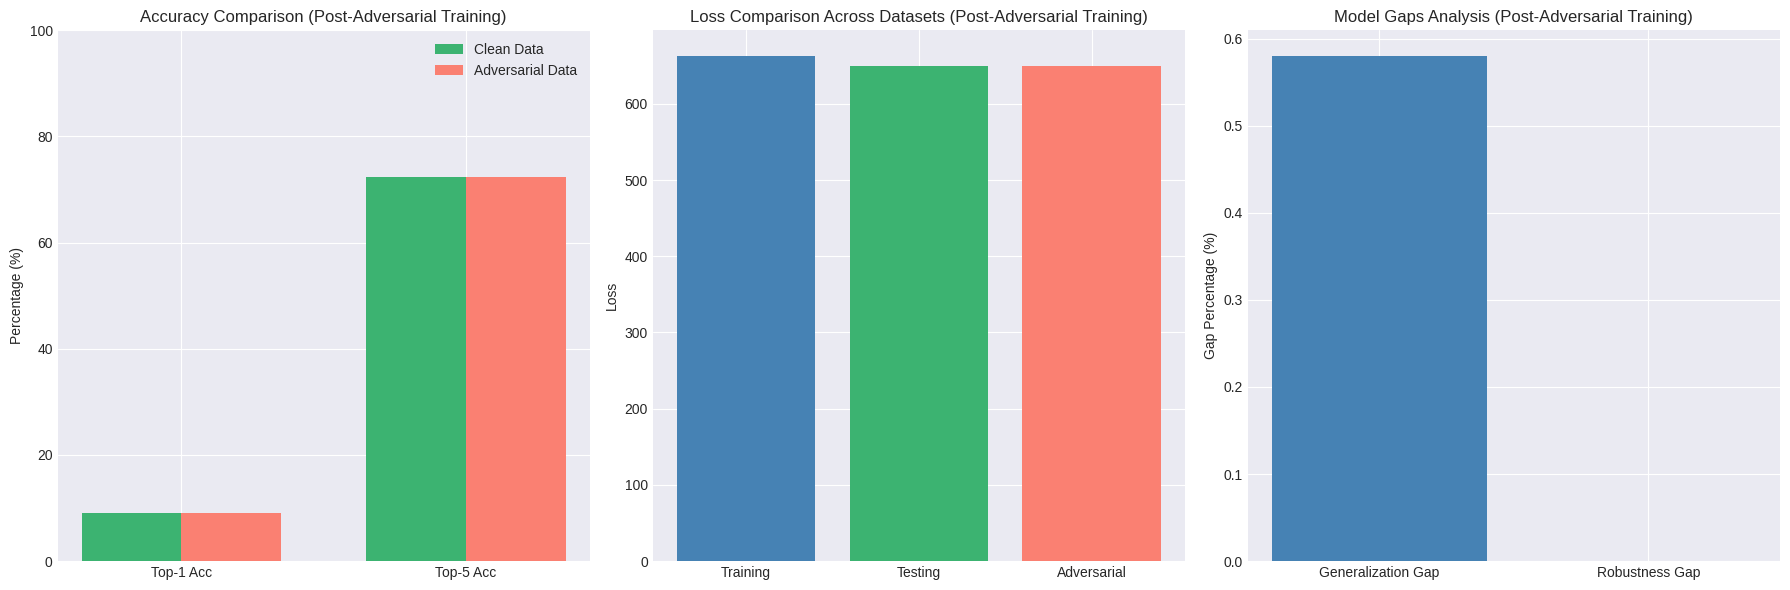

## Adversarial Performance Metrics 📊
Clean Data Accuracy: `9.04%`
Adversarial Data Accuracy: `9.04%`
Robustness Gap: `0.00%`
Top-1 Accuracy: `9.04%`
Top-5 Accuracy: `72.33%`
Loss: `649.356`

## Generalization Analysis 🧠
Training Accuracy: `9.62%`
Test Accuracy: `9.04%`
Generalization Gap: `0.58%`
Training Loss: `663.298`
Test Loss: `649.356`
> *A smaller gap indicates better generalization*


In [ ]:
import os
# 0 = all logs, 1 = filter INFO, 2 = filter INFO & WARNING, 3 = filter INFO, WARNING & ERROR
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # use "3" to hide even ERROR logs

import tensorflow as tf

# Silence TensorFlow's Python logger as well
tf.get_logger().setLevel("ERROR")

# Silence absl logs that TF uses
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# # If on TF 1.x APIs:
try:
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
except Exception:
    pass

import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
IMG_SIZE = 224
BATCH_SIZE = 500
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 5 # Changed to a lower number for demonstration if retraining is needed
tf.random.set_seed(5)

physical_gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_gpus)

try:
    tf.keras.mixed_precision.set_global_policy('float32') # Ensured float32 policy as per the original notebook
    if physical_gpus: # Check if GPUs are available before setting virtual device
        tf.config.experimental.set_virtual_device_configuration(
            physical_gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=56320)]  # Limit RAM to 55GB to avoid starving PC
        )
        print("Using GPU with 55GB of memory")
except Exception as e:
    print(e)

# Load ImageNet data
def prepare_input_data(input):
    image = tf.cast(input['image'], tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) # Corrected to use the casted image
    image = preprocess_input(image)
    label = input['label']
    return image, label

dataset, info = tfds.load(
    'imagenette',
    shuffle_files=False,
    with_info=True,
    data_dir=dataset_dir,
)


print(f'Train image count: {info.splits["train"].num_examples}')
print(f'Test image count: {info.splits["validation"].num_examples}')

train_dataset = dataset['train'].map(prepare_input_data, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = dataset['validation'].map(prepare_input_data, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Load ResNet50 model
base_model = ResNet50(
    include_top=True,
    weights=None,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling=None,
    classes=10,
    classifier_activation='softmax'
)

# Functions for adversarial data generation and loading
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _create_adversary_with_pgd(model, images, labels, eps, eps_iter, nb_iter):
    x_adv = tf.identity(images)
    # Use from_logits=False because classifier_activation='softmax' means model outputs probabilities
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    for _ in range(nb_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            prediction = model(x_adv, training=False)
            loss = loss_object(labels, prediction)

        gradients = tape.gradient(loss, x_adv)
        signed_grad = tf.sign(gradients)
        x_adv = x_adv + eps_iter * signed_grad
        perturbation = tf.clip_by_value(x_adv - images, -eps, eps)
        x_adv = images + perturbation

    return x_adv

def generate_adversarial_dataset(filename, dataset, model, eps, pgd_steps, pgd_step_size):
    options = tf.io.TFRecordOptions(compression_type="GZIP")
    num = 0
    with tf.io.TFRecordWriter(filename, options=options) as writer:
        for i, (images, labels) in enumerate(dataset):
            print(f"Batch {i+1}")
            adv_images = _create_adversary_with_pgd(
                model=model,
                images=images,
                labels=labels,
                eps=eps,
                eps_iter=pgd_step_size,
                nb_iter=pgd_steps
            )

            for i in range(len(adv_images)):
                image_tensor = adv_images[i]
                label = labels[i]
                image_tensor_f16 = tf.cast(image_tensor, tf.float16)
                image_bytes = tf.io.serialize_tensor(image_tensor_f16)
                feature = {
                    'image': _bytes_feature(image_bytes),
                    'label': _int64_feature(label.numpy())
                }
                num += 1
                serialized_example = tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()
                writer.write(serialized_example)
    print(f"Processed and saved: {num} images")

def _parse_function(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    image_f16 = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float16)
    label = parsed_features['label']
    image_f32 = tf.cast(image_f16, tf.float32)
    image_f32.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return image_f32, label

# Create adversarial dataset (uncomment to run generation)
adversarial_test_file = f"{dataset_dir}/adversaries/small_test_dataset.tfrec"
adversarial_train_file = f"{dataset_dir}/adversaries/small_train_dataset.tfrec"

loaded_test_dataset = tf.data.TFRecordDataset(adversarial_test_file, compression_type='GZIP')
parsed_test_dataset = loaded_test_dataset.map(_parse_function).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

base_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
    ]
)

print("Training baseline model...\n")
base_model.fit(train_dataset, verbose=1, batch_size=BATCH_SIZE, epochs=4)

print("Computing baseline metrics...\n")

train_metrics = base_model.evaluate(train_dataset, verbose=1)
test_metrics = base_model.evaluate(test_dataset, verbose=1)
noisy_metrics = base_model.evaluate(parsed_test_dataset, verbose=1)

# Extract metrics
try:
    metric_names = ['loss', 'accuracy', 'top_5_accuracy']
    metrics_dict = {
        'train': dict(zip(metric_names, train_metrics)),
        'test': dict(zip(metric_names, test_metrics)),
        'noisy': dict(zip(metric_names, noisy_metrics))
    }

    train_loss, train_acc, train_top5 = metrics_dict['train'].values()
    test_loss, test_acc, test_top5 = metrics_dict['test'].values()
    noisy_loss, noisy_acc, noisy_top5 = metrics_dict['noisy'].values()

except Exception as e:
    print(f"Error extracting metrics: {e}")

print("## Baseline Performance Metrics 📊")
print(f"Clean Data Accuracy: `{test_acc*100:.2f}%`")
print(f"Adversarial Data Accuracy: `{noisy_acc*100:.2f}%`")
print(f"* Robustness Gap: `{(test_acc-noisy_acc)*100:.2f}%`")

print("\n" + "---")
print(f"Top-1 Accuracy: `{test_acc*100:.2f}%`")
print(f"Top-5 Accuracy: `{test_top5*100:.2f}%`")
print(f"Loss: `{test_loss:.3f}`")


# Adversarial training
loaded_train_dataset = tf.data.TFRecordDataset(adversarial_train_file, compression_type='GZIP')
parsed_train_dataset = loaded_train_dataset.map(_parse_function).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Adversarial Training robust model...\n")

robust_model = ResNet50(
    include_top=True,
    weights=None,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling=None,
    classes=10,
    classifier_activation='softmax'
)
robust_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
    ]
)
robust_model.fit(parsed_train_dataset, verbose=1, batch_size=BATCH_SIZE, epochs=4)

train_metrics_adv = robust_model.evaluate(parsed_train_dataset, verbose=1)
test_metrics_adv = robust_model.evaluate(test_dataset, verbose=1)
noisy_metrics_adv = robust_model.evaluate(parsed_test_dataset, verbose=1)

try:
    metrics_dict_adv = {
        'train': dict(zip(metric_names, train_metrics_adv)),
        'test': dict(zip(metric_names, test_metrics_adv)),
        'noisy': dict(zip(metric_names, noisy_metrics_adv))
    }

    train_loss_adv, train_acc_adv, train_top5_adv = metrics_dict_adv['train'].values()
    test_loss_adv, test_acc_adv, test_top5_adv = metrics_dict_adv['test'].values()
    noisy_loss_adv, noisy_acc_adv, noisy_top5_adv = metrics_dict_adv['noisy'].values()

except Exception as e:
    print(f"Error extracting metrics after adversarial training: {e}")
    print("Available metrics:", base_model.metrics_names)
    raise

# Create figure for multiple plots - After adversarial training
plt.style.use('seaborn-v0_8-darkgrid') # Updated style for better visuals
fig = plt.figure(figsize=(18, 6)) # Larger figure size

# 1. Accuracy Comparison (Post-Adversarial Training)
plt.subplot(1, 3, 1)
metrics = ['Top-1 Acc', 'Top-5 Acc']
clean_scores_post_adv = [test_acc_adv*100, test_top5_adv*100]
noisy_scores_post_adv = [noisy_acc_adv*100, noisy_top5_adv*100]

x = range(len(metrics))
width = 0.35

plt.bar([i - width/2 for i in x], clean_scores_post_adv, width, label='Clean Data', color='mediumseagreen')
plt.bar([i + width/2 for i in x], noisy_scores_post_adv, width, label='Adversarial Data', color='salmon')
plt.ylabel('Percentage (%)')
plt.title('Accuracy Comparison (Post-Adversarial Training)')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 100) # Set y-limit for better comparison

# 2. Loss Comparison (Post-Adversarial Training)
plt.subplot(1, 3, 2)
plt.bar(['Training', 'Testing', 'Adversarial'],
        [train_loss_adv, test_loss_adv, noisy_loss_adv],
        color=['steelblue', 'mediumseagreen', 'salmon'])
plt.ylabel('Loss')
plt.title('Loss Comparison Across Datasets (Post-Adversarial Training)')

# 3. Robustness Gap (Post-Adversarial Training)
plt.subplot(1, 3, 3)
plt.bar(['Generalization Gap', 'Robustness Gap'],
        [(train_acc_adv - test_acc_adv)*100, (test_acc_adv - noisy_acc_adv)*100],
        color=['steelblue', 'salmon'])
plt.ylabel('Gap Percentage (%)')
plt.title('Model Gaps Analysis (Post-Adversarial Training)')

plt.tight_layout()
plt.show()

# Print detailed metrics report (Post-Adversarial Training)
print("## Adversarial Performance Metrics 📊")
print(f"Clean Data Accuracy: `{test_acc_adv*100:.2f}%`")
print(f"Adversarial Data Accuracy: `{noisy_acc_adv*100:.2f}%`")
print(f"Robustness Gap: `{(test_acc_adv-noisy_acc_adv)*100:.2f}%`")

print(f"Top-1 Accuracy: `{test_acc_adv*100:.2f}%`")
print(f"Top-5 Accuracy: `{test_top5_adv*100:.2f}%`")
print(f"Loss: `{test_loss_adv:.3f}`")

print("\n## Generalization Analysis 🧠")
print(f"Training Accuracy: `{train_acc_adv*100:.2f}%`")
print(f"Test Accuracy: `{test_acc_adv*100:.2f}%`")
print(f"Generalization Gap: `{(train_acc_adv-test_acc_adv)*100:.2f}%`")
print(f"Training Loss: `{train_loss_adv:.3f}`")
print(f"Test Loss: `{test_loss_adv:.3f}`")
print("> *A smaller gap indicates better generalization*")

